In [1]:
# 참고 : https://sike6054.github.io/blog/paper/fifth-post/

# [Xception]

*KU LeeDongGyu*

## Contents
---

1. Data Preprocessing
```
1) Data Import
2) Data Augmentation
```
2. Support Functions & Almost Original Xception
```
1) Support Functions
2) Almost Original Xception
3) Xception Evaluate
```



### Install Packages


### Module

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/Colab Notebooks/Paper

/content/drive/My Drive/Colab Notebooks/Paper


In [4]:
from f1score import macro_f1score,weighted_f1score

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, ZeroPadding2D ,GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, AveragePooling2D , ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model , load_model , Sequential
from tensorflow.keras.utils import plot_model , to_categorical, get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Paper'

In [7]:
print(tf.__version__)
print(ks.__version__)

2.3.0
2.4.0


In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3049649215914751049
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3580490506980823853
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8523663058671214039
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15473775744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15803976895724421525
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


## 1. Data Preprocessing
---

### 1) Data Import

In [10]:
# 바꿔서 살펴 볼 것들
# CALTECH, CIFAR100, FER, MIT
data_name = 'CALTECH'
gan_type = 'No_GAN'
number = '1'
size = 299 # sizes after cropping
super_size = 330 # sizes before cropping 
input_sizes = (size,size,3)
batch_sizes = 32
weight_decay = 1e-6
epochs = 50

In [11]:
# 참고 : https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras/52897216#52897216
# setting the seed number for random number generation for reproducibility.

from numpy.random import seed
import random


if number=='1':
    seed_num = 200225
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='2':
    seed_num = 727
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='3':
    seed_num = 115
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='4':
    seed_num = 501
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='5':
    seed_num = 517
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [12]:
# data import

if data_name=='FER' :
    x_train =  np.zeros(28698)
    x_valid = np.zeros(3589)
    x_test = np.zeros(3588)
    classes = 7 
    tr_center = [0.50793296, 0.50793296, 0.50793296]
elif data_name=='MIT':
    x_train = np.zeros(12466)
    x_valid = np.zeros(1564)
    x_test = np.zeros(1590)
    classes = 67 
    tr_center = [0.47916578, 0.42029615, 0.36046057]
elif data_name=='CALTECH':
    x_train = np.zeros(24510)
    x_valid = np.zeros(2980)
    x_test = np.zeros(3118)
    classes = 257
    tr_center = [0.51397761, 0.49525248, 0.46555727]
elif data_name=='CIFAR100':
    x_train = np.zeros(39941)
    x_valid = np.zeros(10059)
    x_test = np.zeros(10000)
    classes = 100
    tr_center = [0.53393271, 0.51324147, 0.46450563]

In [13]:
dir = os.path.join(os.getcwd(),data_name,gan_type)

### 2) Data Augmentation

In [14]:
# 참고 : https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3 # img.shape[2] 가 3(rgb)이 아니면 assertion error 발생
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [15]:
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import glob

# 데이터 전체에 대해 centering 진행함.

def read_cal_image(img_path): 
    x = img_to_array(load_img(img_path)) # x는 채널별 평균값
    y = x.shape[0] * x.shape[1]# y는 데이터별 픽셀 수 (비중)

    x = 1/255. * x # scaling하고, centering값을 뽑아냄.
    x = np.mean(x, axis=(0,1))
    
    return np.hstack([x,y])

def calculate_centered_mean(dataset_path,x_train=x_train):
    num = len(x_train)
    space = np.empty((num,4))
    i=0

    for p in glob.glob(os.path.join(dataset_path,'*/*.*')) :
        space[i] = read_cal_image(p)
        i += 1

    ratio = space[:,3] / np.sum(space[:,3])

    return np.average(space[:,0:3],axis=0,weights=ratio)


# 아래의 함수를 돌려서 나온 결과값을 중심화 값으로 설정.

# train_mean = calculate_centered_mean(os.path.join(dir,'data/train')).reshape((1,1,3))

In [16]:
datagen_tr = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.9,1.0],
    fill_mode = 'nearest')
datagen_val = ImageDataGenerator(rescale=1/255.,featurewise_center=True)
datagen_tes = ImageDataGenerator(rescale=1/255.,featurewise_center=True)

# 원래는 이 자리에 fit 매서드를 써야하지만, 그냥 내가 중심화함수를 만들고 적용함. 

# 중심화 설정
datagen_tr.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_val.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_tes.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB

In [17]:
train_batches = datagen_tr.flow_from_directory(directory=os.path.join(dir,'data/train'),target_size=(super_size,super_size),batch_size=batch_sizes,class_mode='categorical') # fer : 28698 / mit : 12466 / caltech : 24509 / cifar : 39941
train_generator= crop_generator(train_batches, size)
valid_generator = datagen_val.flow_from_directory(directory=os.path.join(dir,'data/valid'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3589 / mit : 1564 / caltech : 2980 / cifar : 10059
test_generator = datagen_tes.flow_from_directory(directory=os.path.join(dir,'data/test'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3588 / mit : 1590 / caltech : 3118 / cifar : 10000

Found 24509 images belonging to 257 classes.
Found 2980 images belonging to 257 classes.
Found 3118 images belonging to 257 classes.


## 2. Support Functions & Almost Original Xception
---

### 1) Support Functions

In [18]:
# def lr_schedule(epoch):
#     init_lr = 1e-4
#     k = 0.04
#     lr = init_lr * np.exp(-k*epoch)
#     print('Learning rate: ', lr)
#     return lr

def lr_schedule(epoch):
    lr = 1e-3
    if epoch < 30:
        lr = lr
    elif epoch < 45:
        lr = lr * 0.1
    else:
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

In [19]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=weight_decay):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

In [20]:
def sepconv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=weight_decay, depth_multiplier=1):
    x = SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, 
                        depthwise_initializer='he_uniform', pointwise_initializer='he_uniform',
                        depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

### 2) Almost Original Xception


In [21]:
def Xception(model_input, classes, name = "Xception"):
    ## Entry flow
    x = conv2d_bn(model_input, 32, (3, 3), strides=2) # (299, 299, 3) -> (150, 150, 32)
    x = conv2d_bn(x, 64, (3, 3))

    for fliters in [128, 256, 728]: # (75, 75, 64) -> (75, 75, 128) -> (38, 38, 256) -> (19, 19, 728)
        residual = conv2d_bn(x, fliters, (1, 1), strides=2, activation=None)
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, fliters, (3, 3))
        x = sepconv2d_bn(x, fliters, (3, 3), activation=None)
        x = MaxPooling2D((3, 3), padding='same', strides=2)(x)
        
        x = Add()([x, residual])
        
        
    ## Middle flow
    for i in range(8): # (19, 19, 728)
        residual = x
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3), activation=None)
        
        x = Add()([x, residual])
        
        
    ## Exit flow
    residual = conv2d_bn(x, 1024, (1, 1), strides=2, activation=None) # (19, 19, 728) -> (10, 10, 1024)
        
    x = Activation(activation='relu')(x)
    x = sepconv2d_bn(x, 728, (3, 3))
    x = sepconv2d_bn(x, 1024, (3, 3), activation=None) # (19, 19, 728) -> (19, 19, 1024)
    x = MaxPooling2D((3, 3), padding='same', strides=2)(x) # (19, 19, 1024) -> (10, 10, 1024)
    
    x = Add()([x, residual])
    
    x = sepconv2d_bn(x, 1536, (3, 3))
    x = sepconv2d_bn(x, 2048, (3, 3))

    x = GlobalAveragePooling2D()(x)
    
    ## Optinal fully-connected layers
    '''
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    '''
    
    x = Dropout(0.5)(x)
    
    model_output = Dense(classes, activation='softmax')(x)

    model = Model(model_input, model_output, name=name)
    
    return model

In [22]:
model_input = Input(shape=input_sizes)
model = Xception(model_input, classes=classes, name='Xception')

In [23]:
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 150, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [24]:
# 폴더 생성

os.makedirs(os.path.join(dir,'model_output',number,model.name), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [25]:
# AdamW 시작 / AdamWR은 epoch을 500번은 돌려야 될 것 같아 힘듦.
# 참고 : https://github.com/OverLordGoldDragon/keras-adamw

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Paper')
import utils
import optimizers_v2
from utils import get_weight_decays, fill_dict_in_order
from utils import reset_seeds, K_eval
from optimizers_v2 import AdamW, NadamW, SGDW

In [26]:
optimizer = AdamW(model=model, use_cosine_annealing=False, total_iterations = len(x_train) // batch_sizes , eta_min = 1e-2)
#optimizer = Adam()
filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')

callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  #ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,min_lr=1e-5),
                  LearningRateScheduler(lr_schedule,verbose=1)
                  ]
                  
model.compile(optimizer, loss = 'categorical_crossentropy', metrics=['accuracy',macro_f1score,weighted_f1score])

In [27]:
######## flow_from_directory
history = model.fit(train_generator, steps_per_epoch=int(len(x_train)/batch_sizes),  validation_data = valid_generator, epochs=epochs, verbose=1 , callbacks = callbacks_list , validation_steps=int(len(x_valid)/batch_sizes))

Learning rate:  0.001

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/50
0.0(L1), 3.615507621182657e-08(L2) weight decay set for conv2d/kernel:0
0.0(L1), 3.615507621182657e-08(L2) weight decay set for conv2d_1/kernel:0
0.0(L1), 3.615507621182657e-08(L2) weight decay set for conv2d_2/kernel:0
0.0(L1), 3.615507621182657e-08(L2) weight decay set for conv2d_3/kernel:0
0.0(L1), 3.615507621182657e-08(L2) weight decay set for conv2d_4/kernel:0
0.0(L1), 3.615507621182657e-08(L2) weight decay set for conv2d_5/kernel:0
765/765 [==============================] - ETA: 0s - loss: 5.1754 - accuracy: 0.0745 - macro_f1score: 5.7095e-04 - weighted_f1score: 2.3732e-05 
Epoch 00001: val_loss improved from inf to 7.97049, saving model to /content/drive/My Drive/Colab Notebooks/Paper/CALTECH/No_GAN/model_output/1/Xception/001.h5

Epoch 00001: val_accuracy improved from -inf to 0.06620, saving model to /content/drive/My Drive/Colab Notebooks/Paper/CALTECH/No_GAN/model_output/1/X

In [28]:
# 1. epoch=maximum
loss , acc, mf1, wf1 = model.evaluate(test_generator,steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Accuracy: %.4f / Test Macro f1: %.4f / Test Weighted f1: %.4f]\n' % (loss,acc,mf1,wf1))

97/97 [==============================] - 1331s 14s/step - loss: 2.1280 - accuracy: 0.6643 - macro_f1score: 0.0721 - weighted_f1score: 0.0025
[Test Loss: 2.1280 /  Test Accuracy: 0.6643 / Test Macro f1: 0.0721 / Test Weighted f1: 0.0025]



In [29]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
f1=history.history['macro_f1score']
val_f1=history.history['val_macro_f1score']
epochs=range(1,len(acc)+1)

data = np.array([epochs,loss,val_loss,acc,val_acc,f1,val_f1]).T

### 3) Xception Evaluate


In [30]:
# data save
# epochs, loss, val_loss, acc, val_acc, f1, val_f1

np.savetxt(os.path.join(dir,'train_valid_output',number,model.name+'.txt'),data)

In [31]:
# data import
data = np.loadtxt(os.path.join(dir,'train_valid_output',number,'Xception.txt'))

In [32]:
epochs=data[:,0]
loss=data[:,1]
val_loss=data[:,2]
acc=data[:,3]
val_acc=data[:,4]

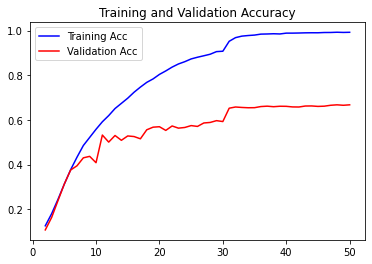

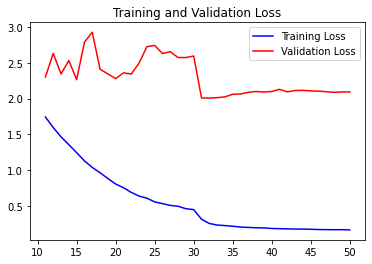

In [33]:
plt.plot(epochs[1:],acc[1:],'b',label='Training Acc')
plt.plot(epochs[1:],val_acc[1:],'r',label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs[10:],loss[10:],'b',label='Training Loss')
plt.plot(epochs[10:],val_loss[10:],'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [34]:
# 이 아래는 내가 인위적으로 살펴보고 싶은 epoch에 대해서 결과값 출력 / Xception

In [35]:
model=load_model(os.path.join(dir,'model_output',number,'Xception','022.h5'),custom_objects={"macro_f1score": macro_f1score,"weighted_f1score":weighted_f1score})

ValueError: ignored

In [ ]:
# 2. epoch=?
loss , acc, mf1, wf1 = model.evaluate(test_generator,steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Accuracy: %.4f / Test Macro f1: %.4f / Test Weighted f1: %.4f]\n' % (loss,acc,mf1,wf1))